# General Notes 

This notebook tests difference combinations of features used in training a BDT tagger for qg discrimination. The default BDT configuration(needs to be tuned) is 

``` python
    dt = DecisionTreeClassifier(max_depth=5,
                                min_samples_leaf=0.002,
                                max_features="log2")
    bdt = AdaBoostClassifier(dt,
                            algorithm='SAMME.R',
                            n_estimators=700,
                            learning_rate=0.001)

```

First section showes the training on all the 5 features, then try just used one feature, Ntrk and compare with Ntrk cut, should expect the same performance. 

2 schemes are used. 
1. Ntrk + a singla feature
2. Exclude one feature from all 5 features. 

In [1]:
# just trainig for all the jets in the pt range (500, 2000) GeV
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc


import uproot 
import awkward as ak


In [2]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22
plt.rcParams['axes.facecolor'] = 'white'

In [3]:
file = "/home/dejavu/Projects/qgcal/Sample_Inspect/dijets_pt_500_2000.npy"
all_jets = np.load(file)

In [4]:
gluon_idx = np.where(all_jets[:,-2]==21)[0]
light_quark_idx = np.where((all_jets[:,-2]==0) | (all_jets[:,-2]==1)| (all_jets[:,-2]==2))[0]
gluon = all_jets[gluon_idx]
quark = all_jets[light_quark_idx]

In [29]:
features_name = ["jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID", "event_weight"]
features_name = np.array(features_name)

In [17]:
gluon[0]

array([ 6.22864188e+05,  1.57242835e-01,  8.00000000e+00,  5.91311324e-03,
        1.44498438e-01, -5.22744119e-01,  2.10000000e+01,  1.00000000e+00])

In [58]:
nevents = 100000
X = np.concatenate((quark[:nevents], gluon[:nevents]), axis=0)
y = np.concatenate((-1.0 * np.ones(nevents), 1.0 * np.ones(nevents)))

In [59]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [70]:
def Draw_ROC(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}')
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

In [75]:
def train_bdt_features(X_train, y_train, X_train_weight, X_test, y_test, X_test_weight, features, y_tmva, y_ntrk):
    print("=====================================================================================================")
    print(f"Traning with features:{features}")
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.metrics import classification_report, roc_auc_score

    dt = DecisionTreeClassifier(max_depth=5,
                                min_samples_leaf=0.002,
                                max_features="log2")
    bdt = AdaBoostClassifier(dt,
                            algorithm='SAMME.R',
                            n_estimators=700,
                            learning_rate=0.001)

    bdt.fit(X_train, y_train, sample_weight=X_train_weight)
    y_test_decisions = bdt.decision_function(X_test)

    
    y_test_gluon_id = np.where(y_test==1)[0]
    y_test_quark_id = np.where(y_test==-1)[0]
    bins_scores = np.linspace(-2.5, 2.5, 50)
    plt.hist(y_test_decisions[y_test_gluon_id], bins_scores, alpha=0.5, label='gluon', color = 'blue')
    plt.hist(y_test_decisions[y_test_quark_id], bins_scores, alpha=0.5, label='quark', color = 'red')
    plt.legend(loc='upper right')
    plt.xlabel("BDT Decision Function")
    plt.ylabel("number of jets")
    plt.title(f"training features: {features}")
    plt.show()

    bins_scores_tmva = np.linspace(-1, 1, 50)
    plt.hist(y_tmva[y_test_gluon_id], bins_scores_tmva, alpha=0.5, label='gluon', color = 'blue')
    plt.hist(y_tmva[y_test_quark_id], bins_scores_tmva, alpha=0.5, label='quark', color = 'red')
    plt.legend(loc='upper right')
    plt.xlabel("BDT Decision Function")
    plt.ylabel("number of jets")
    plt.title("Previous TMVA trainig BDT Response")
    plt.show()

    Draw_ROC(y=y_test,y_tmva = y_tmva, y_ntrk=y_ntrk, decisions = y_test_decisions, X_weight=X_test_weight, features=features)

## 5 features training

Traning with features:['jet_pt' 'jet_eta' 'jet_nTracks' 'jet_trackWidth' 'jet_trackC1']


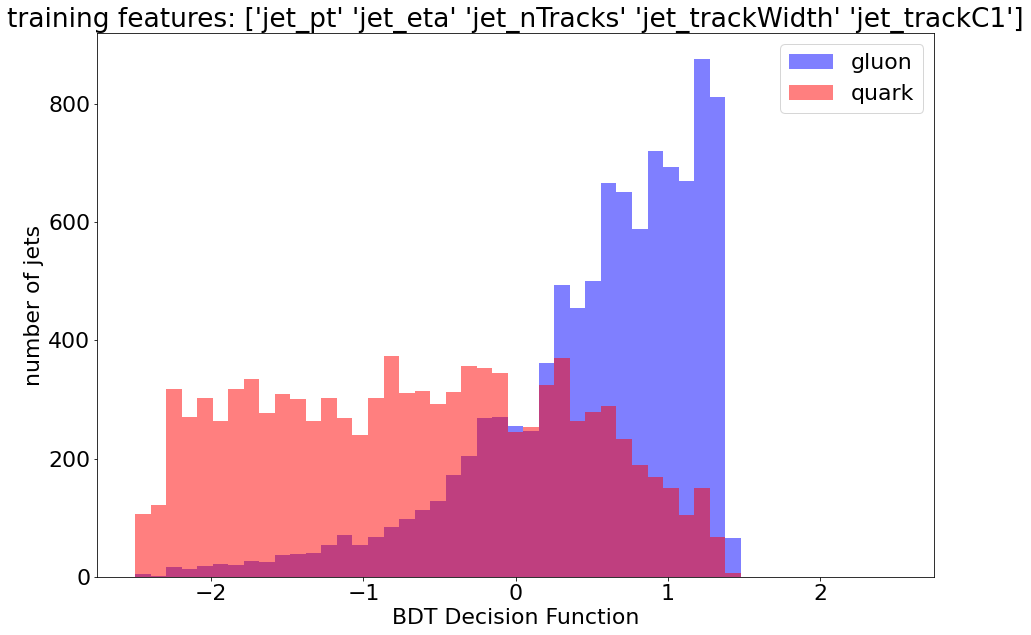

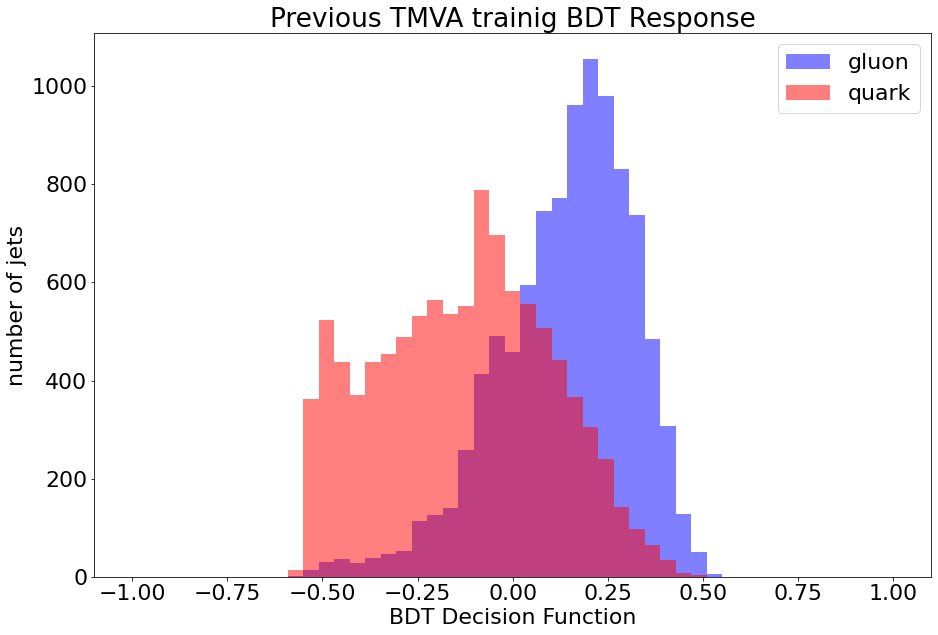

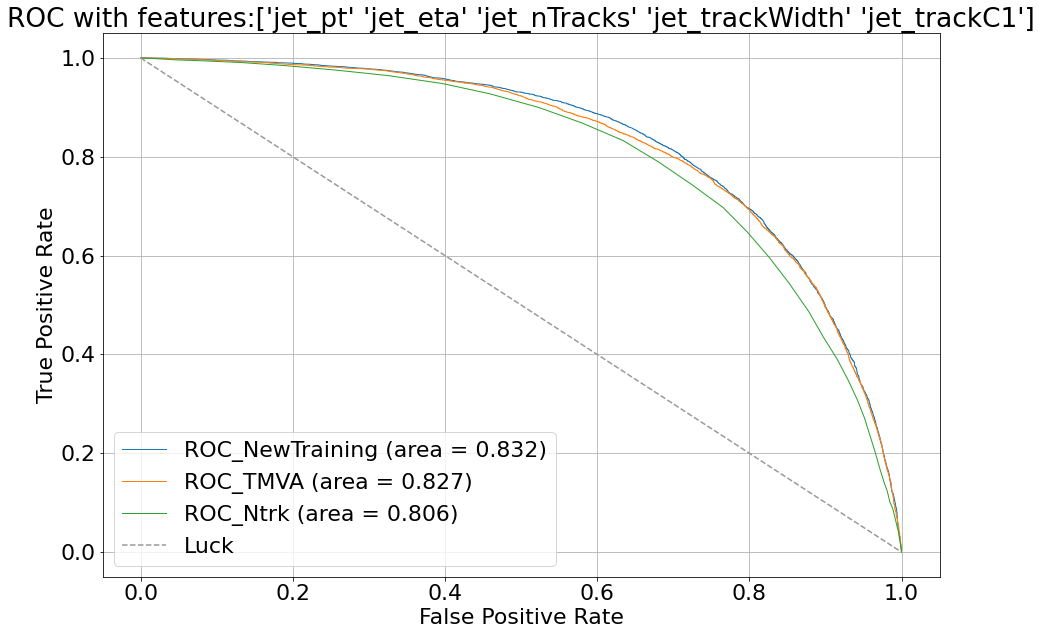

In [76]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22
train_bdt_features(X_train[:,:5], y_train, X_train_weight=X_train[:,-1], 
                    X_test=X_test[:,:5], y_test=y_test, X_test_weight= X_test[:,-1],
                    features = features_name[0:5], y_tmva=X_test[:,-3] , y_ntrk=X_test[:,2])

## Signle Ntrk training

Traning with features['jet_nTracks']


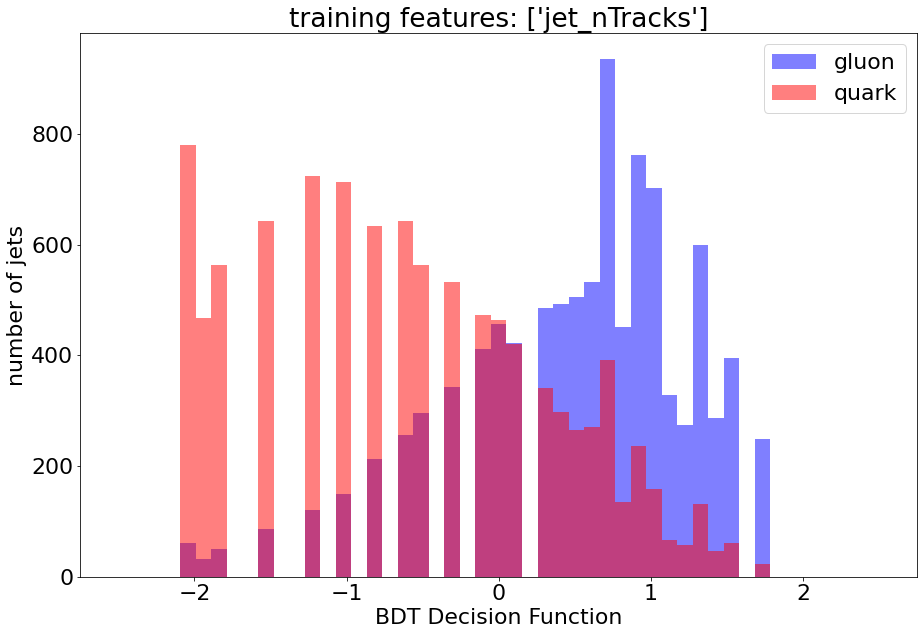

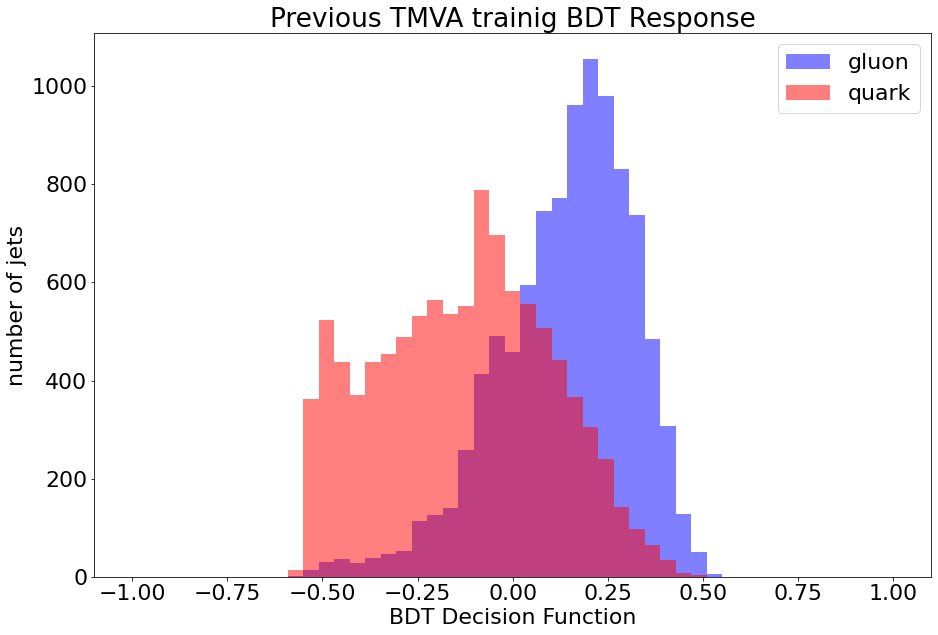

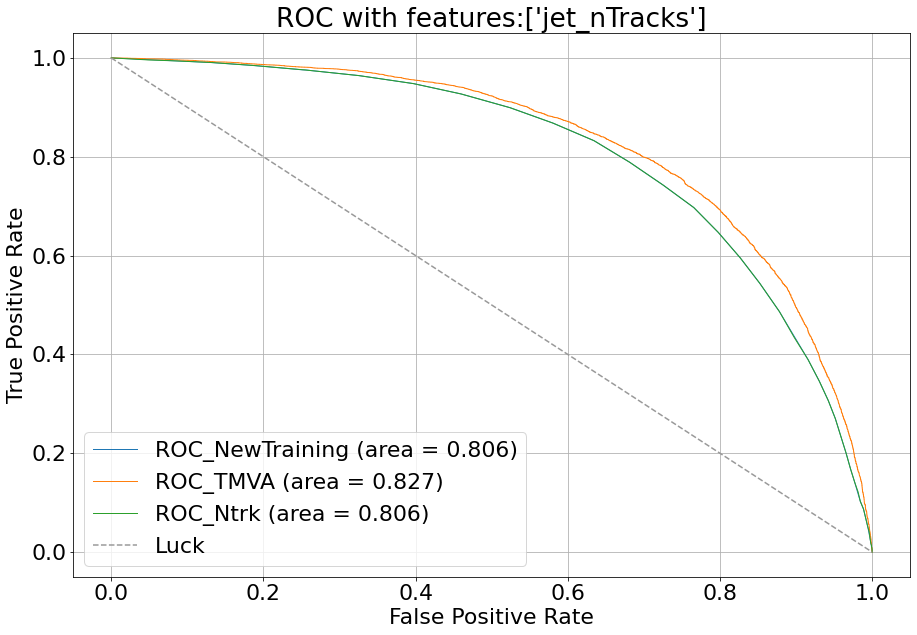

In [74]:
single_ntrk_idx = np.r_[2]
train_bdt_features(X_train[:,single_ntrk_idx], y_train, X_train_weight=X_train[:,-1], 
                    X_test=X_test[:,single_ntrk_idx], y_test=y_test, X_test_weight= X_test[:,-1],
                    features = features_name[single_ntrk_idx], y_tmva=X_test[:,-3] , y_ntrk=X_test[:,2])

## Ntrk + 1 Var training

Traning with features:['jet_nTracks' 'jet_pt']


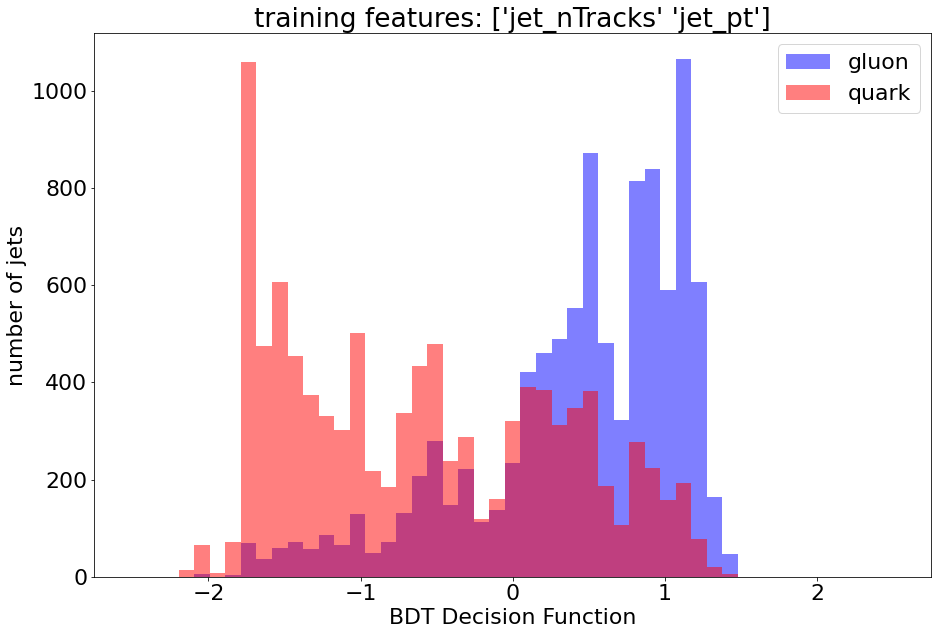

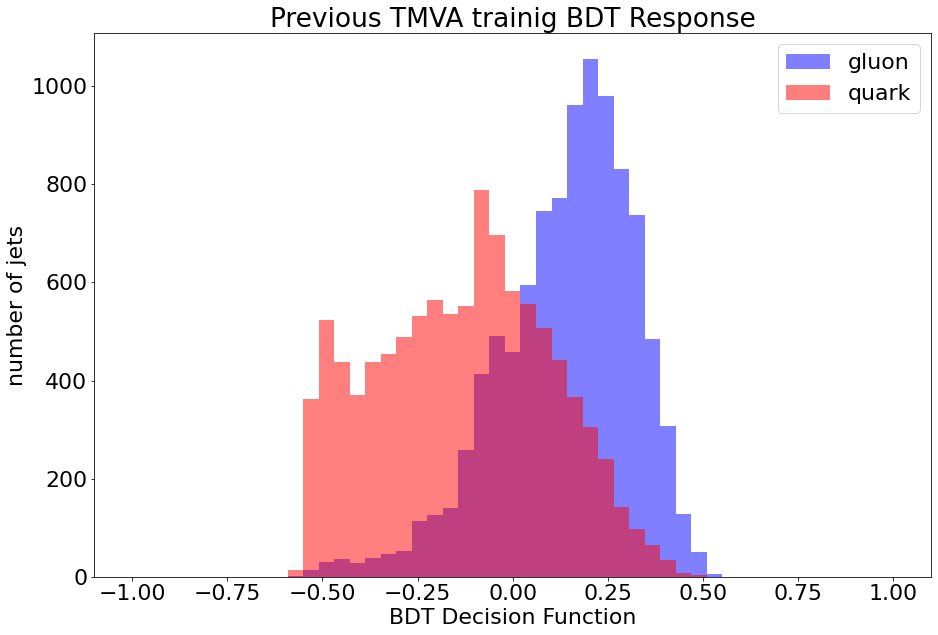

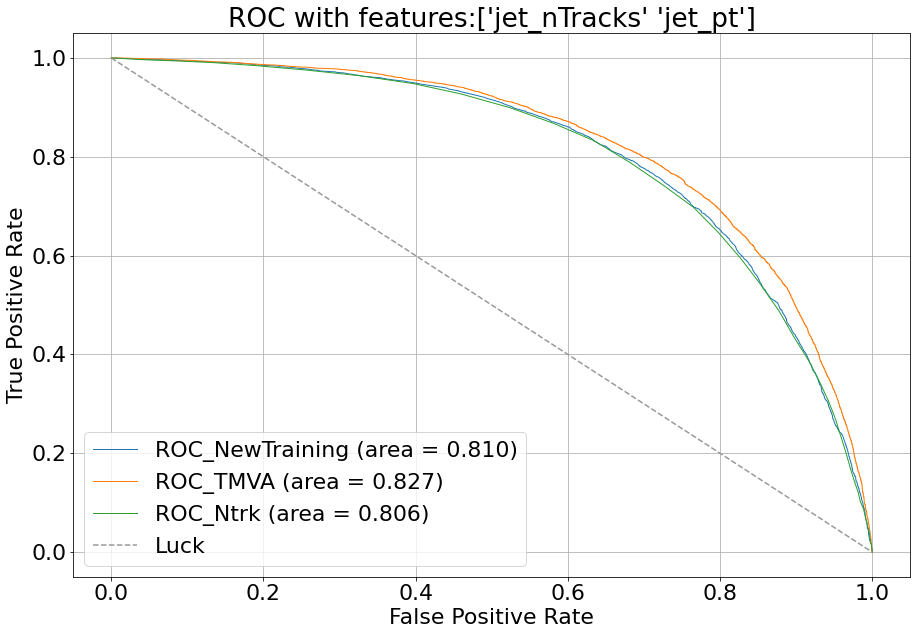

Traning with features:['jet_nTracks' 'jet_eta']


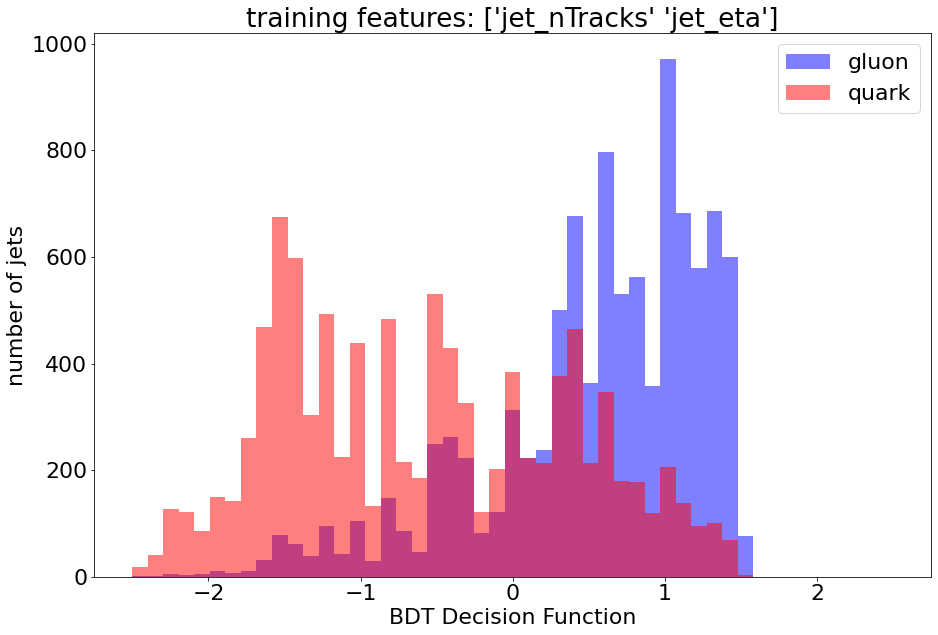

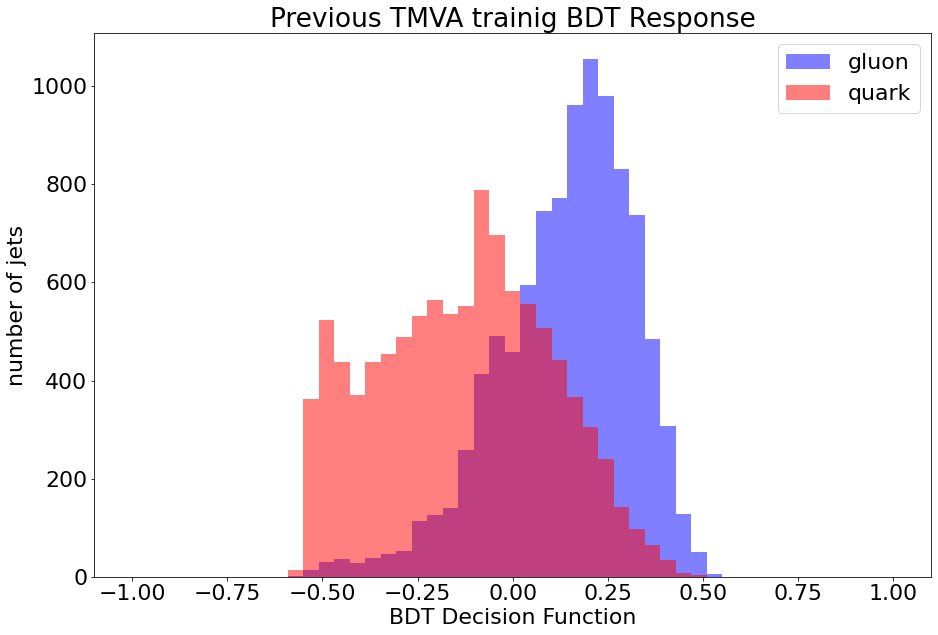

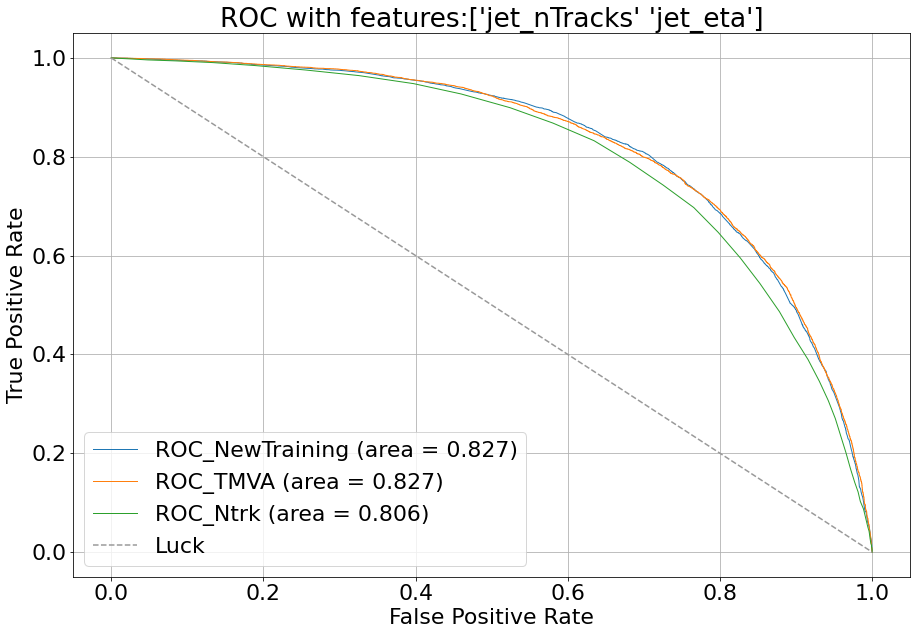

Traning with features:['jet_nTracks' 'jet_trackWidth']


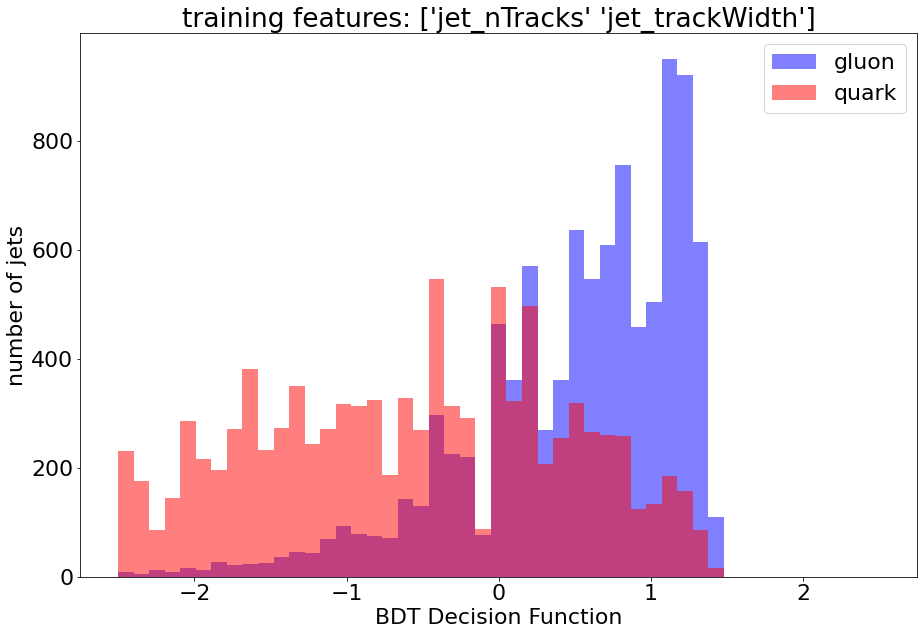

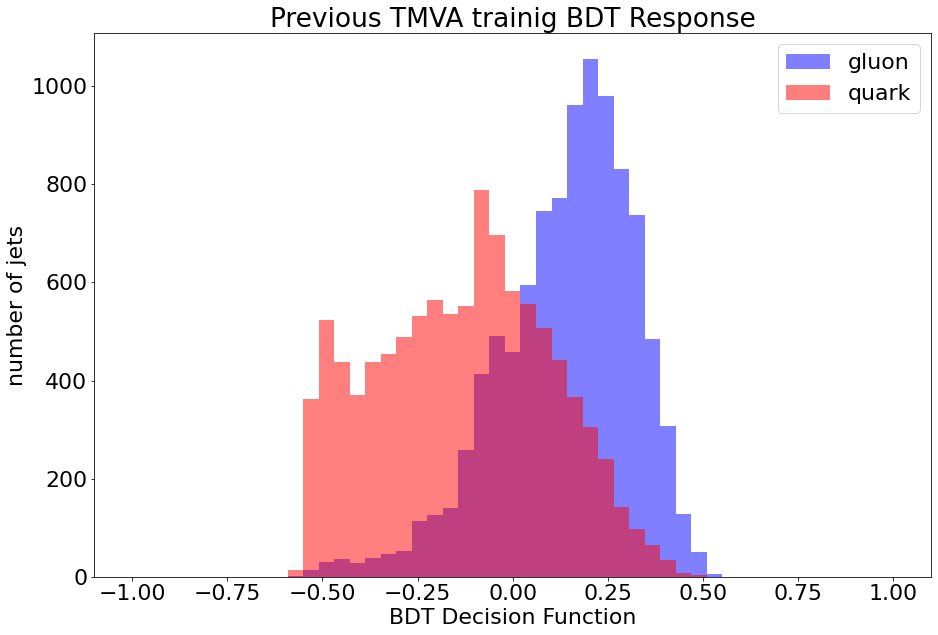

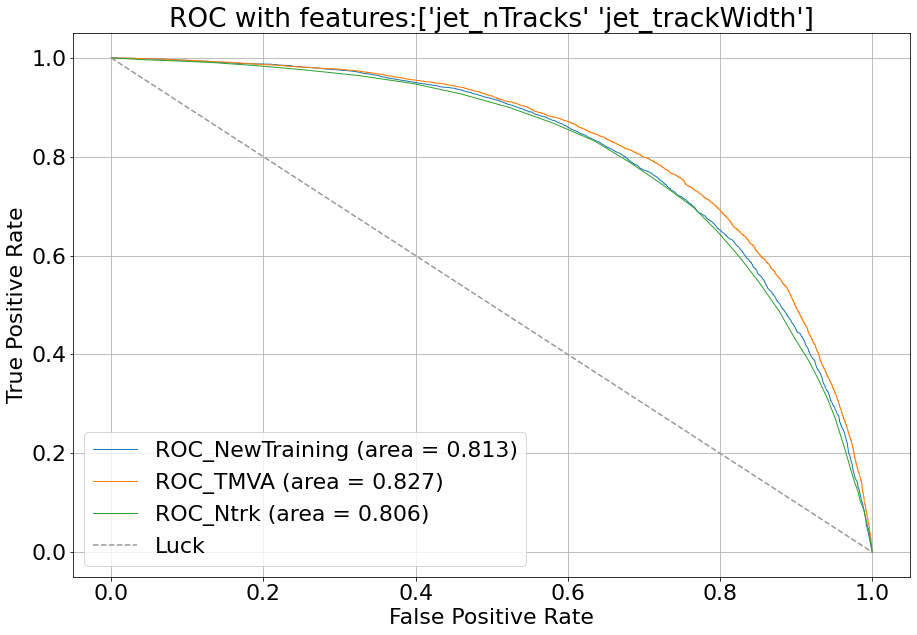

Traning with features:['jet_nTracks' 'jet_trackC1']


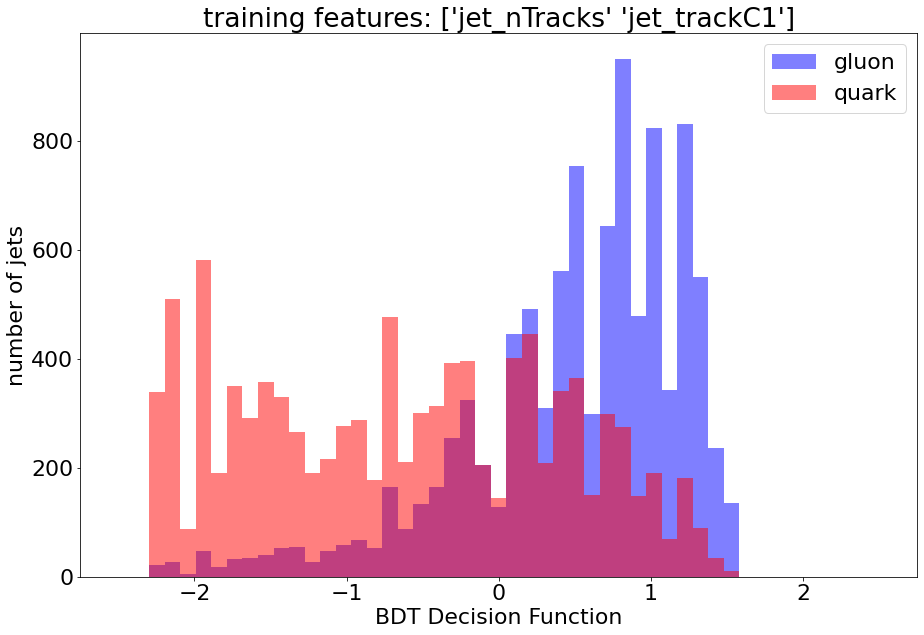

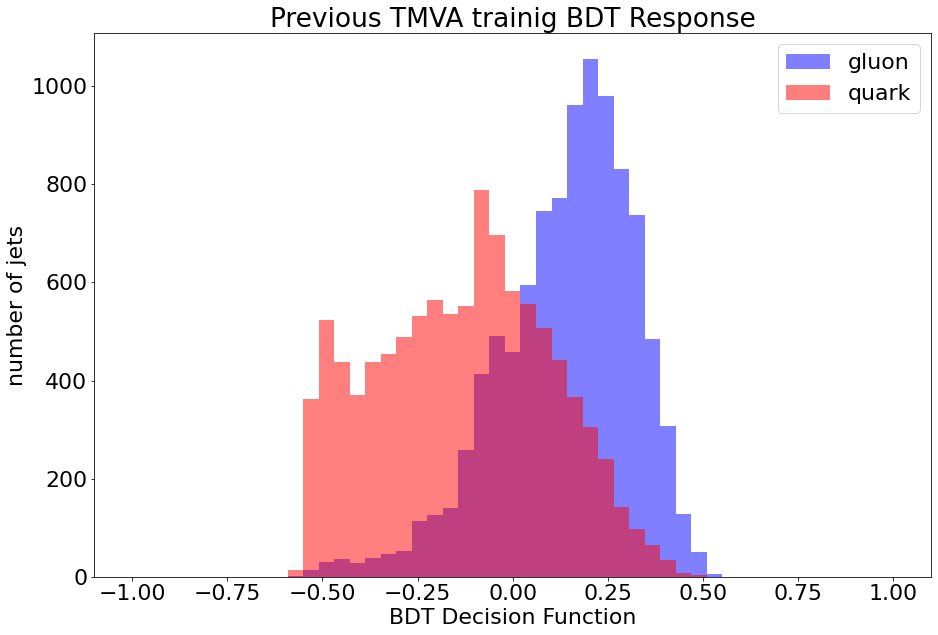

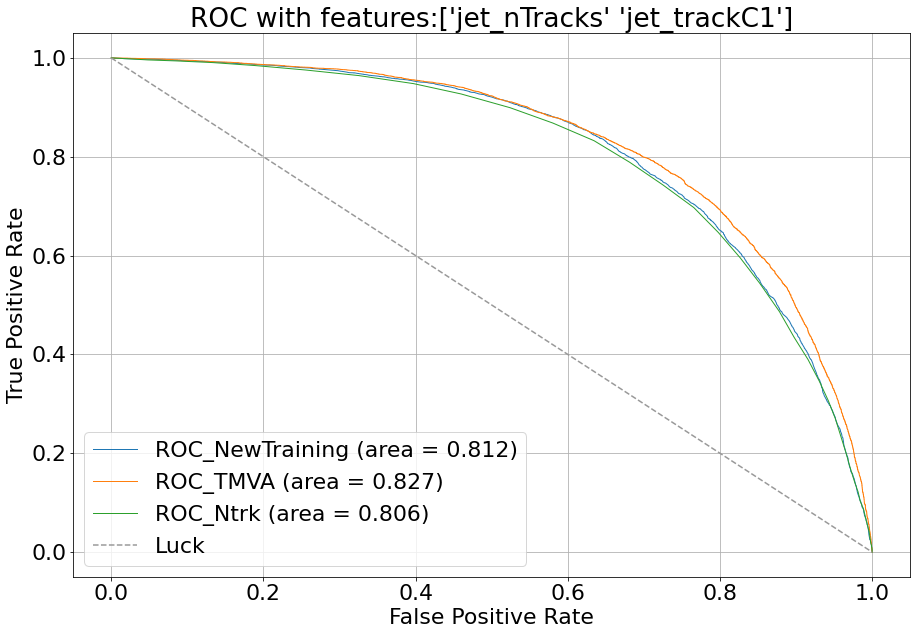

In [79]:
for i in range(5):
    if i != 2:
        featrues_idx = np.r_[2, i]
        train_bdt_features(X_train[:,featrues_idx], y_train, X_train_weight=X_train[:,-1], 
                    X_test=X_test[:,featrues_idx], y_test=y_test, X_test_weight= X_test[:,-1],
                    features = features_name[featrues_idx], y_tmva=X_test[:,-3] , y_ntrk=X_test[:,2])


## 5 features minus one feature

Traning with features:['jet_eta' 'jet_nTracks' 'jet_trackWidth' 'jet_trackC1']


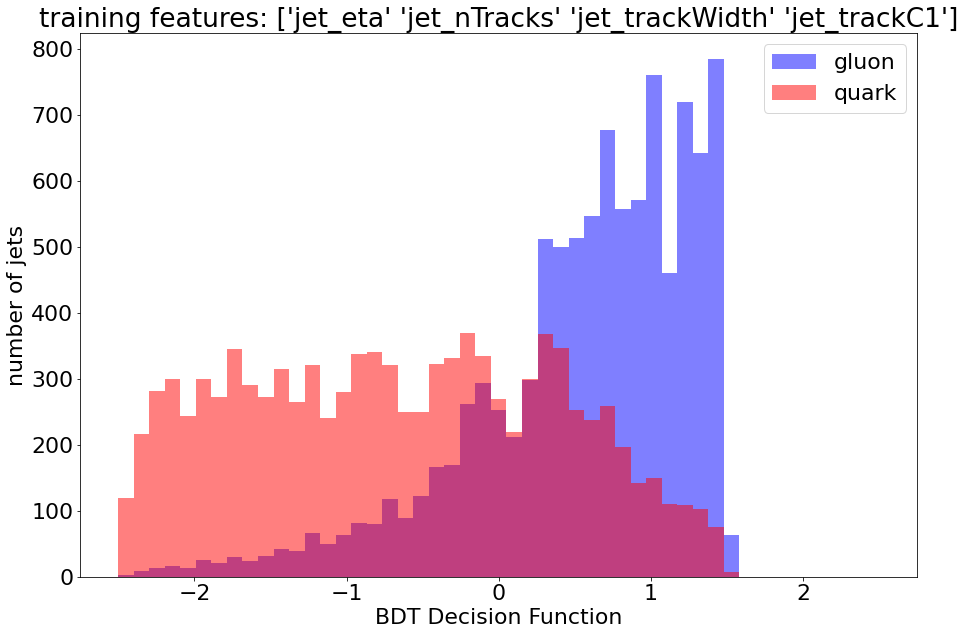

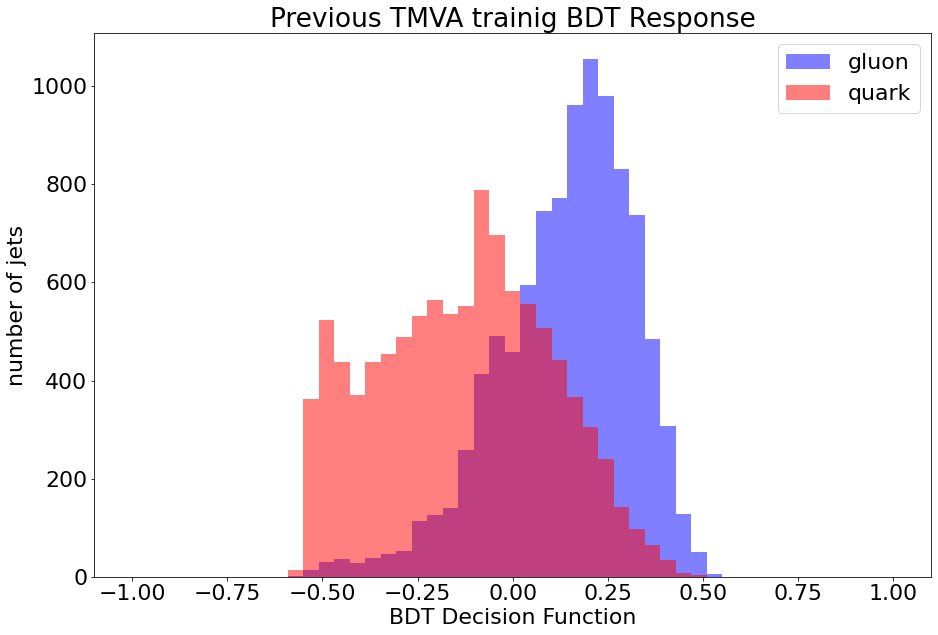

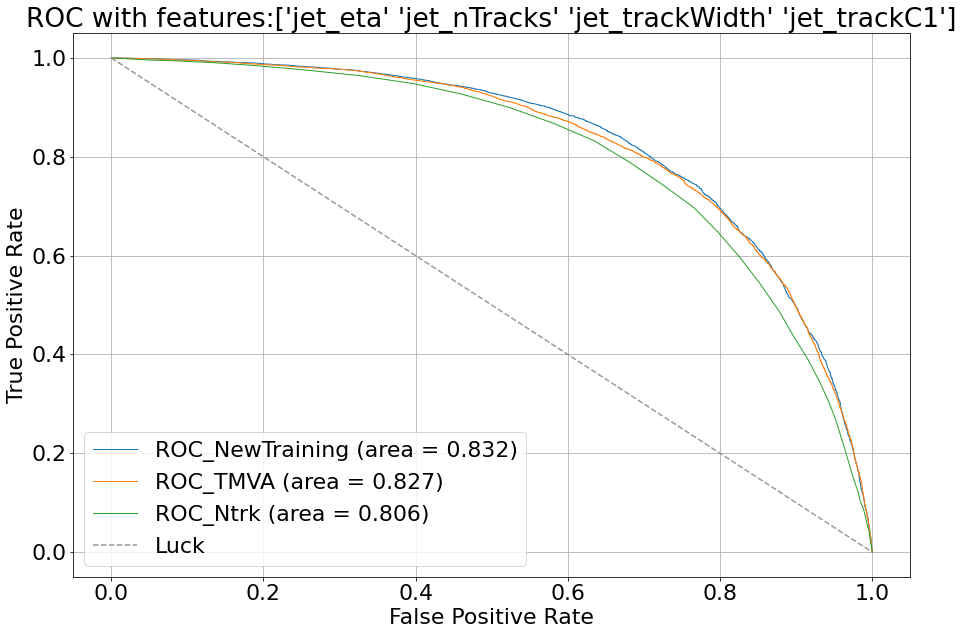

Traning with features:['jet_pt' 'jet_nTracks' 'jet_trackWidth' 'jet_trackC1']


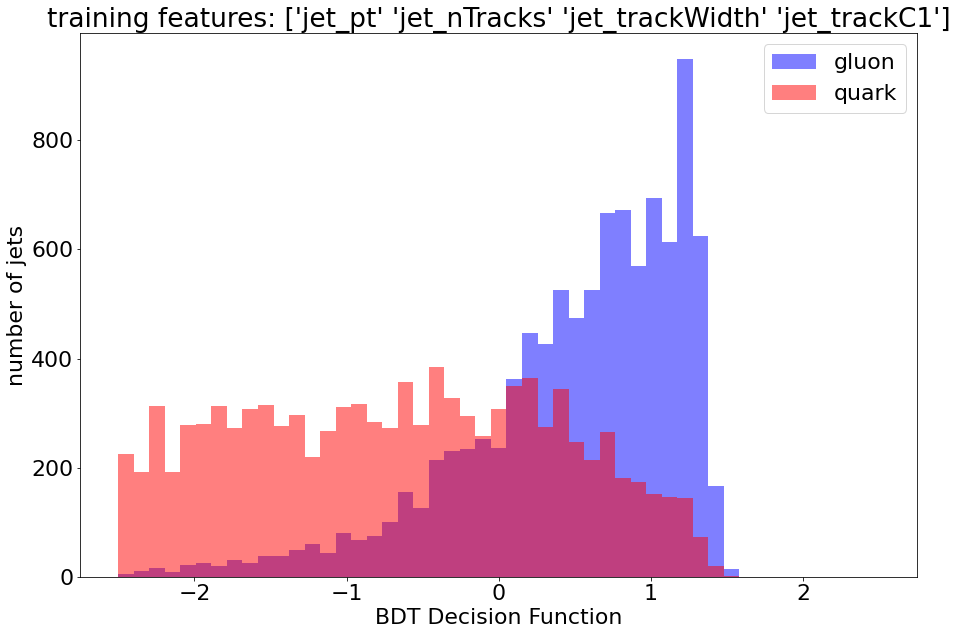

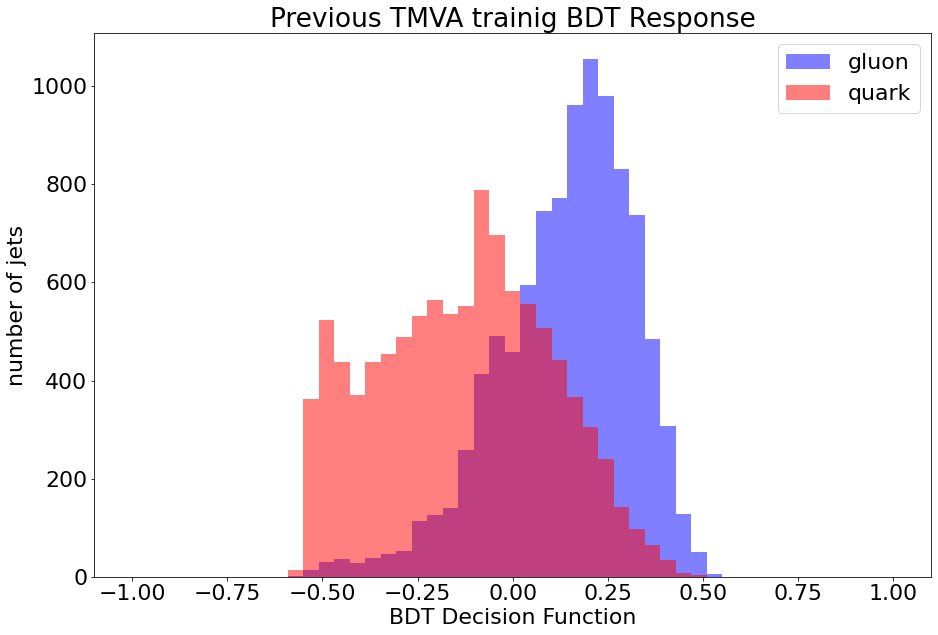

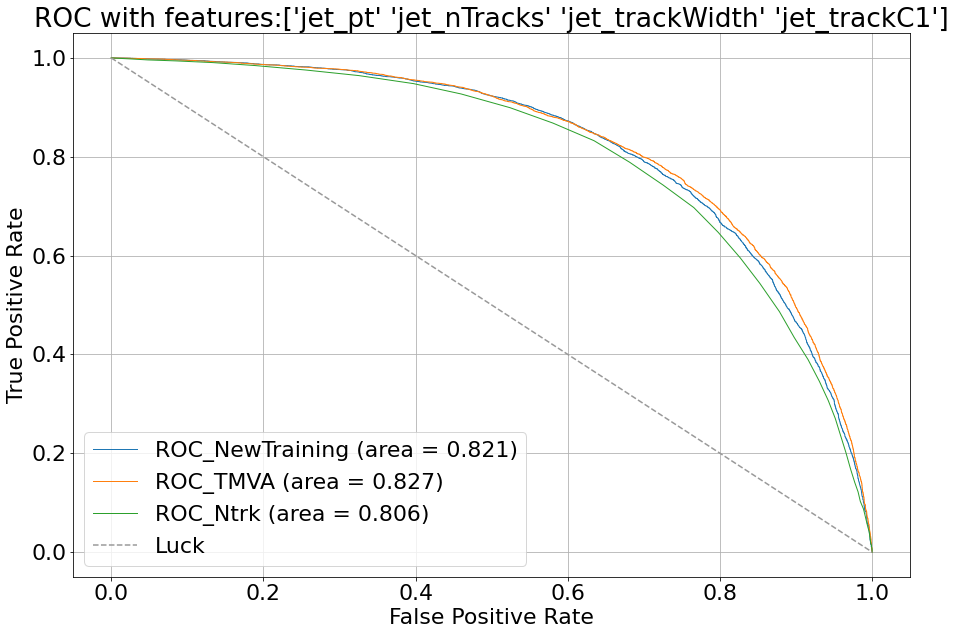

Traning with features:['jet_pt' 'jet_eta' 'jet_nTracks' 'jet_trackC1']


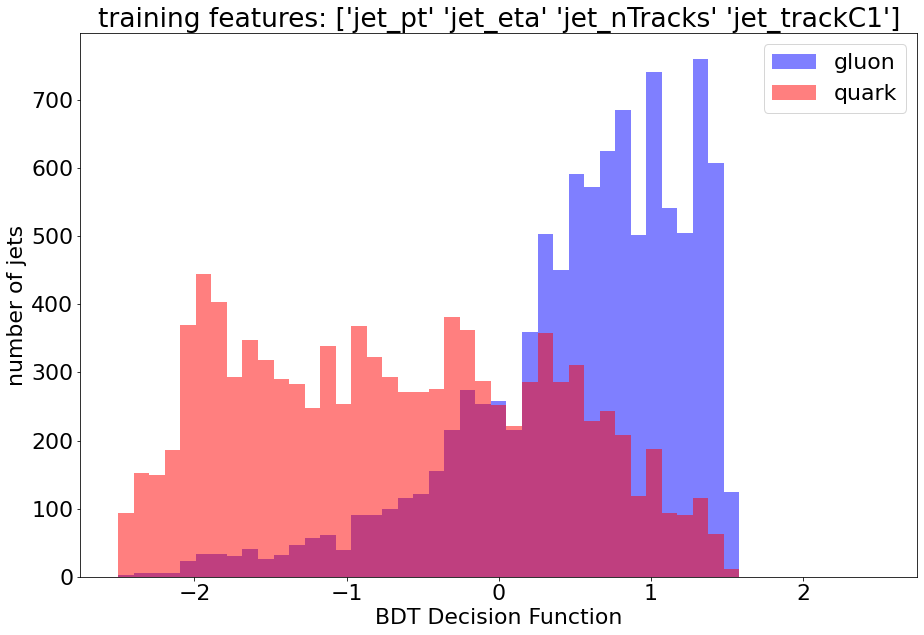

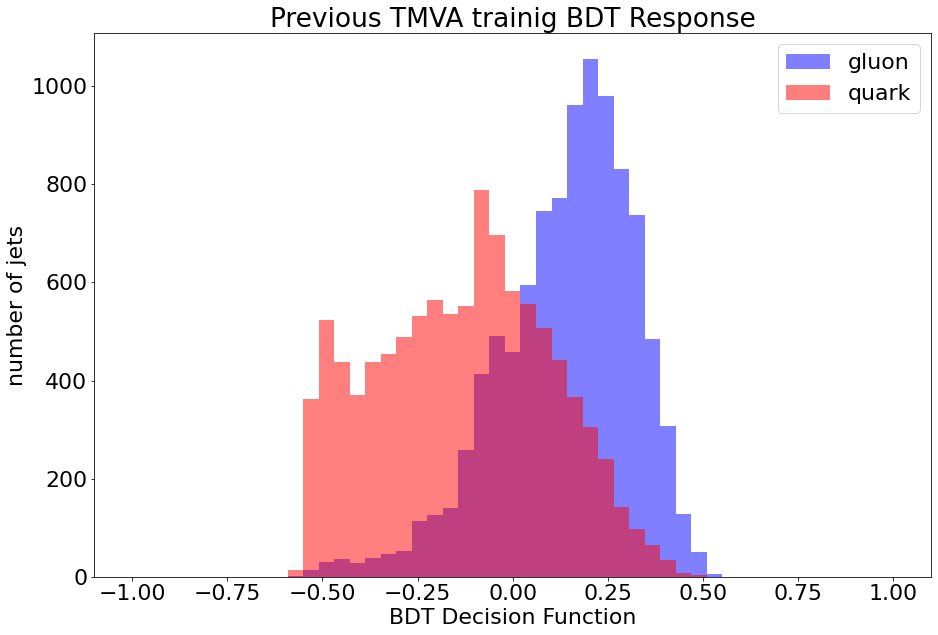

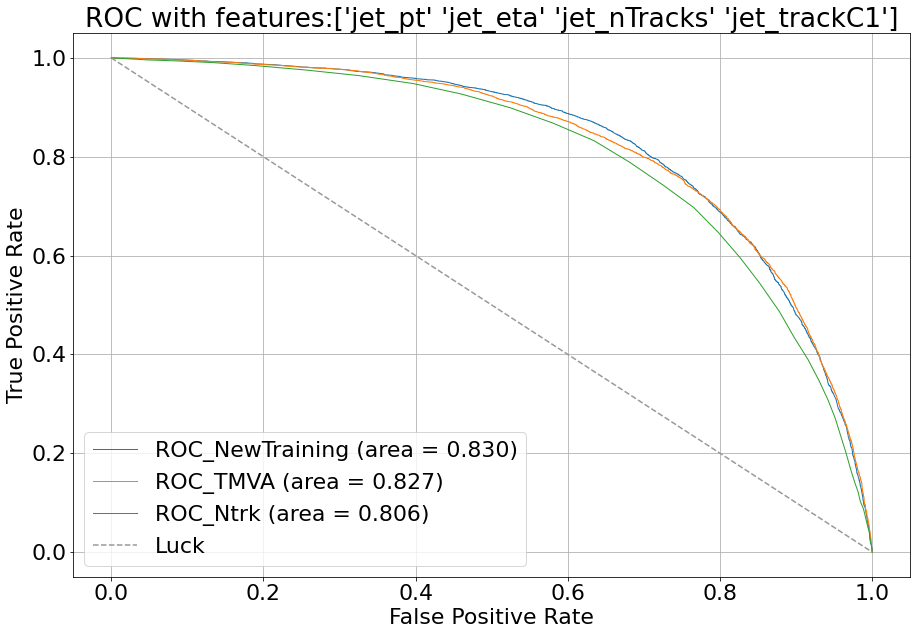

Traning with features:['jet_pt' 'jet_eta' 'jet_nTracks' 'jet_trackWidth']


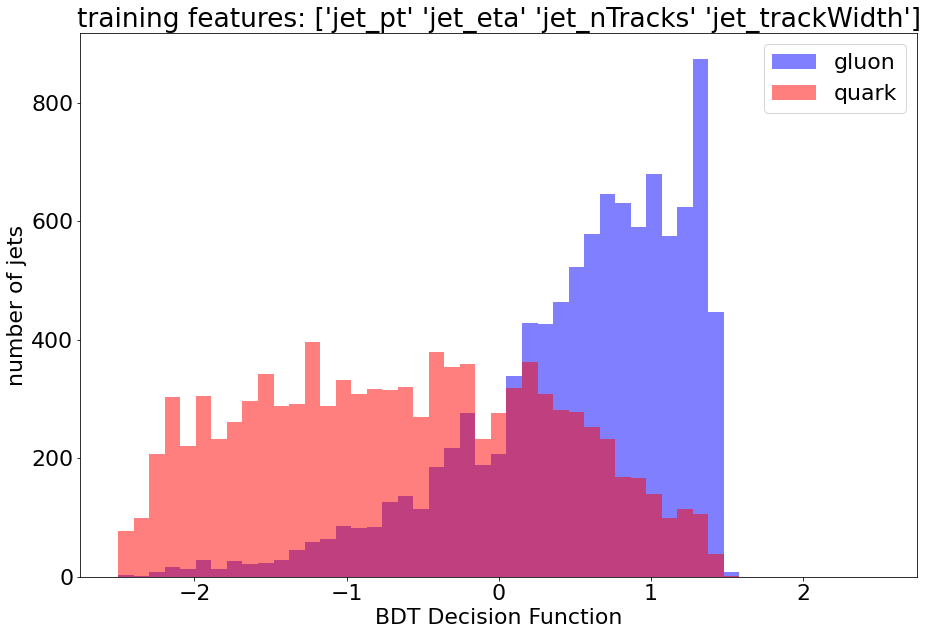

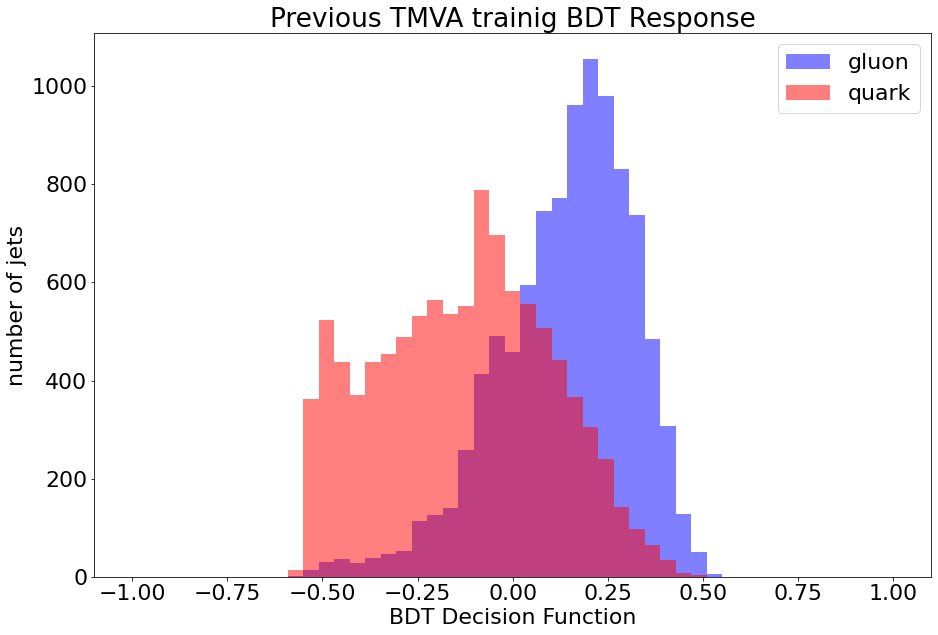

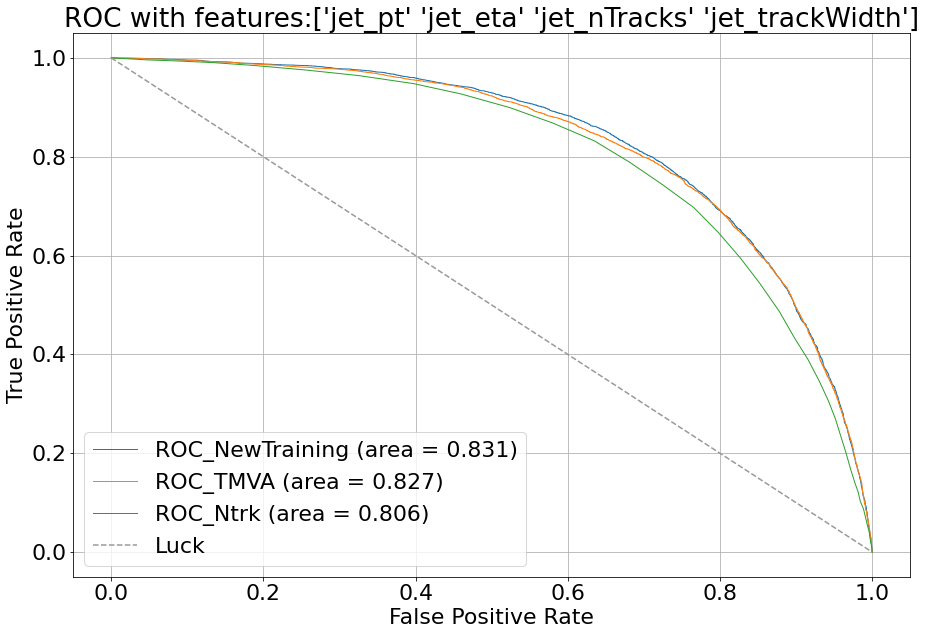

In [78]:
all_idx = np.arange(0,5)
for i in range(5):
    if i!= 2:
        featrues_idx = [idx for idx in all_idx if idx != i]
        train_bdt_features(X_train[:,featrues_idx], y_train, X_train_weight=X_train[:,-1], 
                        X_test=X_test[:,featrues_idx], y_test=y_test, X_test_weight= X_test[:,-1],
                        features = features_name[featrues_idx], y_tmva=X_test[:,-3] , y_ntrk=X_test[:,2])


## Bakcup Codes

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=5,
                            min_samples_leaf=0.002,
                            max_features="log2")
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME.R',
                         n_estimators=800,
                         learning_rate=0.001)

In [18]:
bdt.fit(X_train[:, :5], y_train, sample_weight=X_train[:,-1])

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         max_features='log2',
                                                         min_samples_leaf=0.002),
                   learning_rate=0.001, n_estimators=800)

In [23]:
y_test_decisions = bdt.decision_function(X_test[:,:5])


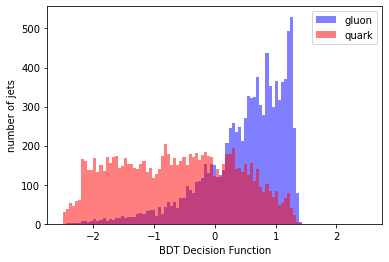

In [28]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==-1)[0]
bins_scores = np.linspace(-2.5, 2.5, 100)
plt.hist(y_test_decisions[y_test_gluon_id], bins_scores, alpha=0.5, label='gluon', color = 'blue')
plt.hist(y_test_decisions[y_test_quark_id], bins_scores, alpha=0.5, label='quark', color = 'red')
plt.legend(loc='upper right')
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.show()

In [27]:
y_predicted = bdt.predict(X_test[:,:5])
print(classification_report(y_test, y_predicted,
                            target_names=["background", "signal"]))
print("Area under ROC curve: %.4f"%(roc_auc_score(y_test,
                                                  bdt.decision_function(X_test[:,:5]),
                                                  sample_weight=X_test[:,-1])))

              precision    recall  f1-score   support

  background       0.78      0.71      0.74     10102
      signal       0.73      0.80      0.76      9898

    accuracy                           0.75     20000
   macro avg       0.76      0.75      0.75     20000
weighted avg       0.76      0.75      0.75     20000

Area under ROC curve: 0.8332


In [ ]:
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test[:,:5])
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y_test, X_test[:,5])
fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y_test, X_test[:,2])

roc_auc = auc(fpr, tpr)
roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))
plt.plot(fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.2f)'%(roc_auc_tmva))
plt.plot(fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.2f)'%(roc_auc_ntrk))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()